# EE596 - Machine Vision
#### Prepared by Paul Adams

##  Report

The most time consuming part of this first assignment was setting up a development environment and deciding on a sufficiently flexible development workflow. 

The main processing code is in the function `find_colorize_binary`, which takes an image, a threshold and a maximum contour line length as inputs and returns the processed images. 

A challenge was in finding an appropriate threshold value for the images. I plotted histograms and could see the bimodal section arouund value 128, however choosing a value half between these two modes didn't result in good segmentation. I also tried Otsu's binarization, but it was biased by the number of pixels near 0. I also tried an adaptive threshold strategy, but it didn't produce good results either. My guess is that since these images are likely machine generated, the lighting is mostly constant over the image and performing local averaging is not helpful. I finally settled on trial and error, using a `for` loop to iterate over several threshold values for each image and selecting the one that led to the best results. 

A second challenge was in removing smaller artifacts, obviously not organs, from the final image. My solution here was to censor contours whose line length was less than a threshold. This assumed that small, unwanted artifacts would have contours with shorter line length than the organs.  

Below is a code listing from the working file and then a short snippet used to display the resultant images. 

## Main Code Listing

In [3]:
#!/usr/bin/env python
import cv2
import numpy as np
from glob import glob
from os import path


def imshow_and_move(im, name, order):
    a = np.shape(im)
    cv2.imshow(name, im)
    cv2.moveWindow(name, (order % 3) * (a[0]), order // 3 * (a[1]))


def find_colorize_binary(im, fullpath, thresh, maxcontour):
    # parse savename
    filename, ext = path.splitext(fullpath)
    filename = path.split(filename)[-1]

    # Threshold
    val, imth = cv2.threshold(im, thresh, 255, cv2.THRESH_BINARY)
    cv2.imwrite("images.out/" + filename + "_thresh" + ext, imth)
    # imth = cv2.adaptiveThreshold(im, 255,
    #                              cv2.ADAPTIVE_THRESH_MEAN_C,
    #                              cv2.THRESH_BINARY, 31, 2)

    # # Initial Closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    im = cv2.morphologyEx(imth, cv2.MORPH_CLOSE, kernel)

    # Opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)

    # Final Closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    cv2.imwrite("images.out/" + filename + "_morph" + ext, im)
    imorph = im

    # Find and Draw Contours
    _, contours, _ = cv2.findContours(im, cv2.RETR_LIST,
                                      cv2.CHAIN_APPROX_NONE)

    im = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    for i in range(len(contours)):
        if len(contours[i]) < maxcontour:
            fillcolor = (0, 0, 0)
        else:
            fillcolor = tuple(np.random.randint(256, size=3))
        cv2.drawContours(im, contours, i, fillcolor, -1)

    cv2.imwrite("images.out/" + filename + "_final" + ext, im)
    return imth, imorph, im


def main():
    # Initialize
    show_images = False
    images = glob(path.join("images.in", "hw1_*.png"))
    maxcontour = 100
    thresh = [131, 133, 131]
    
    # Loop, Process, and Display
    for idx, fullpath in enumerate(images):
        im = cv2.cvtColor(cv2.imread(fullpath), cv2.COLOR_BGR2GRAY)
        im1, im2, im3 = find_colorize_binary(im, fullpath, thresh[idx], maxcontour)
        
        if show_images:
            imshow_and_move(im, "Original: " + fullpath, 0)
            imshow_and_move(im1, "Threshold: thresh %d" % thresh[idx], 1)
            imshow_and_move(im2, "Morphology: " + fullpath, 2)
            imshow_and_move(im3, "Colored: " + fullpath, 3)

            # Closing
            cv2.waitKey(0)
            cv2.destroyAllWindows()


if __name__ == '__main__':
    main()

## Load and Display Resultant Images

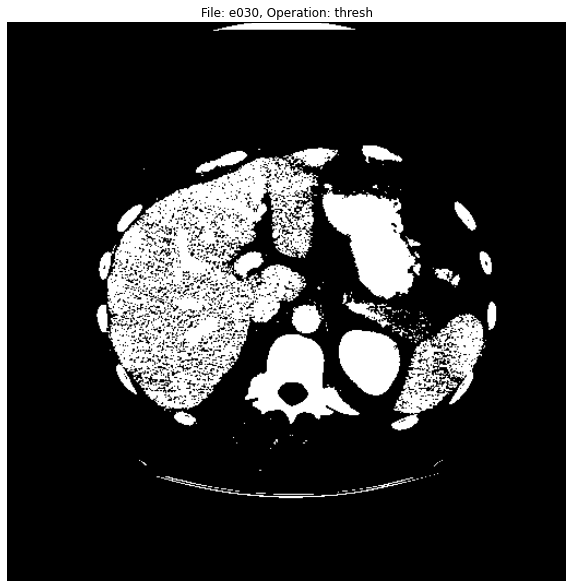

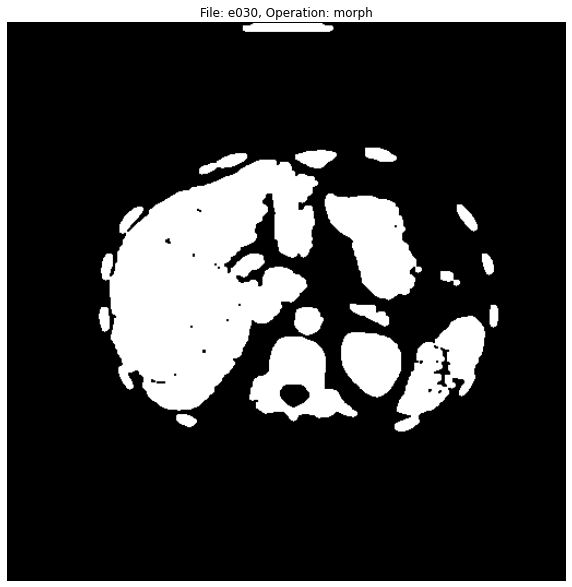

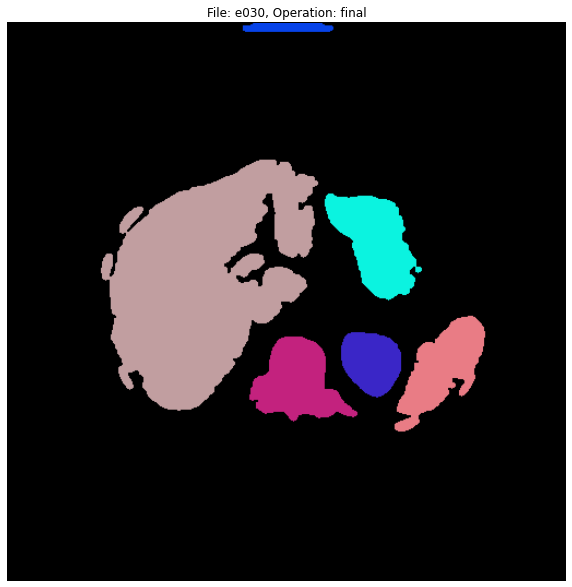

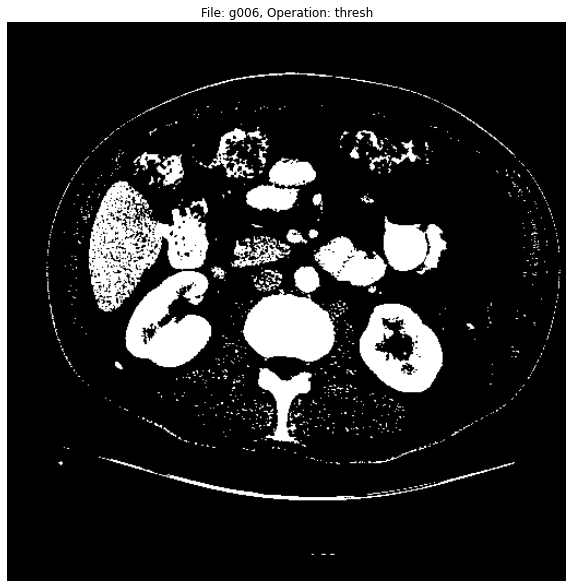

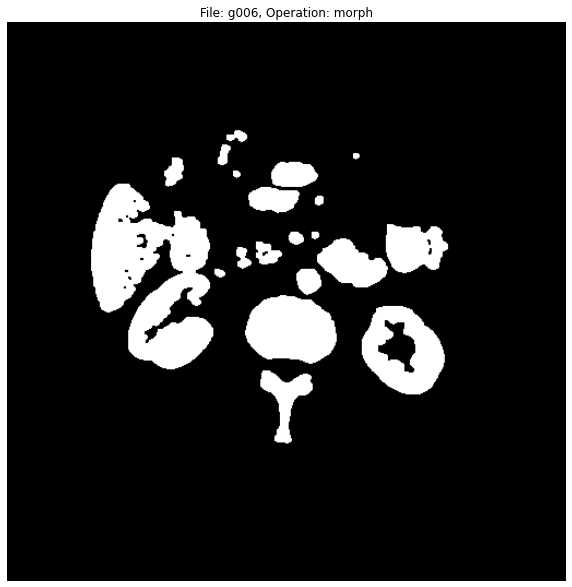

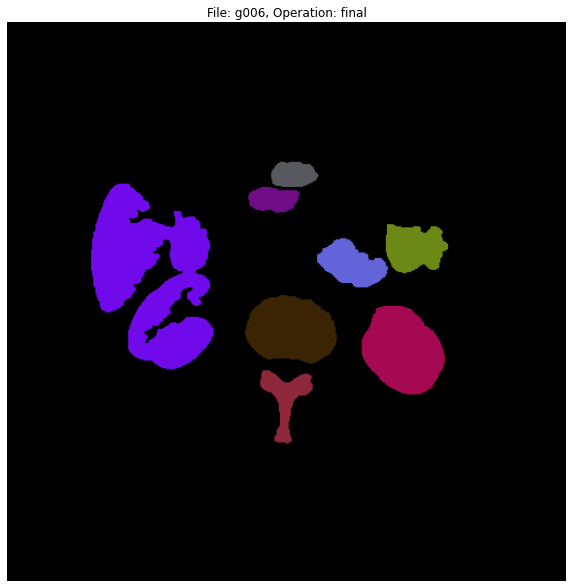

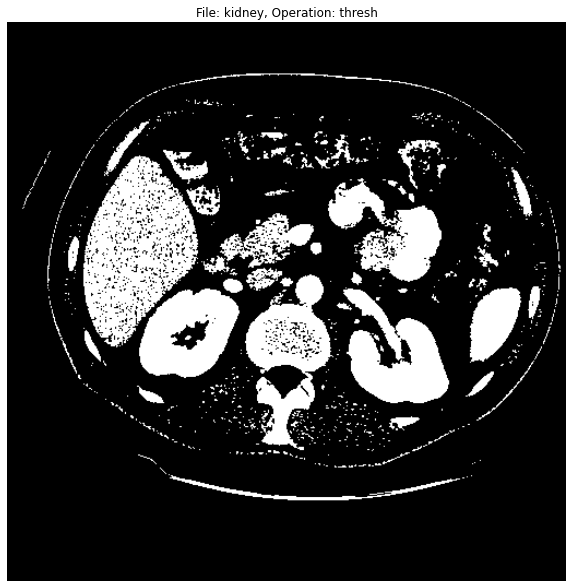

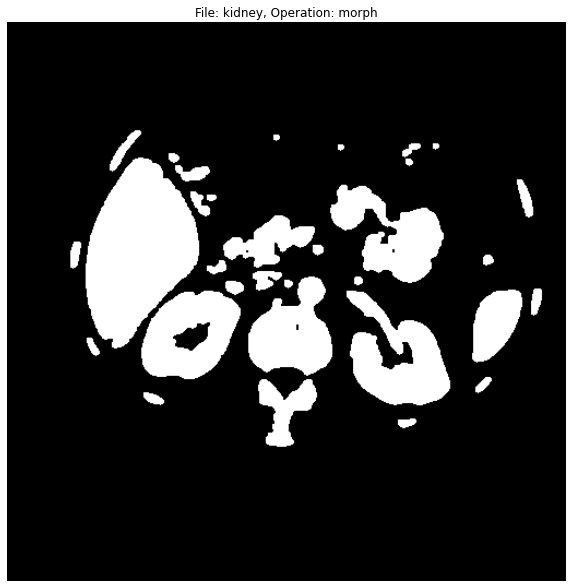

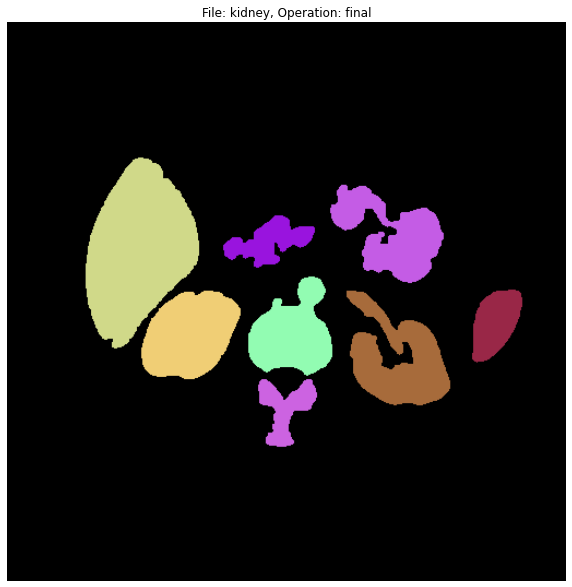

In [4]:
%matplotlib inline
import cv2
from glob import glob
from os import path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def imshow_wrapper(im, ax, name):
    ax.imshow(im)
    ax.set_title(name)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# Show images
imgnames = ["e030", "g006", "kidney"]
operations = ["thresh", "morph", "final"]

for name in imgnames:
    for op in operations:
        f = plt.figure(figsize = (10, 10))
        ax = f.add_subplot(111)
        im = cv2.imread(glob(path.join("images.out", "*%s*%s*.png" % (name, op)))[0])
        imshow_wrapper(im, ax, "File: %s, Operation: %s" % (name, op))
                        